[![Open in Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/Azie88/Coachella-Tweet-Sentiment-Analysis/blob/main/Sentiment_Analysis_Coachella.ipynb)


# Sentiment Analysis Using Colab and Huggingface

What's Deep Learning? It is machine learning based on artificial neural networks in which multiple layers of processing are used to extract progressively higher level features from data.

In this project, we will fine-tune a pre-trained Deep Learning model from HuggingFace on a new dataset ([Coachella 2015 tweet sentiment](https://https://www.kaggle.com/datasets/thedevastator/twitter-sentiment-analysis-coachella-festival)) to adapt the model to our sentiment analysis task, then create an app to use the model and deploy the app on the HuggingFace platform.

## Install Libraries and Packages

In [1]:
!pip install datasets
!pip install evaluate
!pip install transformers[torch]
!pip install accelerate -U

## Import Libraries and Packages

In [2]:
#System and data handling
import os
import re
import warnings
import pandas as pd
pd.set_option('display.max_colwidth', None)
import numpy as np

#Data Analysis & Preparation
from evaluate import load
from collections import Counter
from datasets import load_dataset

#Scikit-Learn
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight

#Google Drive
from google.colab import drive

#Visualization
import matplotlib.pyplot as plt
from wordcloud import WordCloud

#Transformers
from transformers import AutoTokenizer, AutoConfig, AutoModelForSequenceClassification, TrainingArguments, Trainer, DataCollatorWithPadding, TFAutoModelForSequenceClassification

#Scores
from scipy.special import softmax

# Deep learning
import torch
from torch import nn

#Huggingface
from huggingface_hub import notebook_login

## Setup

In [3]:
# Set a fixed random seed for PyTorch on CPU
torch.manual_seed(42)

# Control the seed for individual GPU operations (optional)
if torch.cuda.is_available:
  torch.backends.cudnn.deterministic = True
  torch.backends.cudnn.benchmark = False
  torch.cuda.manual_seed_all(42)


In [4]:
# Set CUDA_LAUNCH_BLOCKING for debugging
os.environ["CUDA_LAUNCH_BLOCKING"] = "1"

## Connect to Google Drive & Load Dataset

In [5]:
# Connect to your google drive

drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [6]:
df = pd.read_csv('/content/drive/MyDrive/Sentiment Analysis NLP/Dataset/Coachella-2015-2-DFE.csv', encoding='latin-1')

## Data Understanding

In [7]:
#look at first 5 rows in train data
df.head()

,coachella_sentiment,coachella_yn,name,retweet_count,text,tweet_coord,tweet_created,tweet_id,tweet_location,user_timezone
0,positive,yes,kokombil,0,#Coachella2015 tickets selling out in less than 40 minutes _Ù_¦_Ù___Ù___Ù÷_ÙÎµ_ÙÎµ_Ù___Ù_¦ http://t.co/SmoXyteIMJ,"[0.0, 0.0]",1/7/15 15:02,5.529630e+17,NaN,Quito
1,positive,yes,MisssTaraaa10,2,RT @sudsybuddy: WAIT THIS IS ABSOLUTE FIRE _ÙÓ´_ÙÓ´_ÙÓ´ #Coachella2015 http://t.co/Ov2eCJtAvR,NaN,1/7/15 15:02,5.529630e+17,united states,NaN
2,positive,yes,NMcCracken805,0,#Coachella2015 #VIP passes secured! See you there bitchesssss,NaN,1/7/15 15:01,5.529630e+17,"Costa Mesa, CA",NaN
3,positive,yes,wxpnfm,1,PhillyÛªs @warondrugsjams will play #Coachella2015 &amp; #GovBall2015! Watch them on Jimmy Fallon: http://t.co/wzaAE5wYNT http://t.co/sFL9I5sD20,NaN,1/7/15 15:01,5.529630e+17,"Philadelphia, PA and Worldwide",Quito
4,positive,yes,Caesears,0,If briana and her mom out to #Coachella2015 im out with them !!! _Ù÷Ý_Ù÷Ý_Ù÷Ý_ÙÕÄ,NaN,1/7/15 15:00,5.529630e+17,NaN,NaN


In [8]:
df.shape

(3846, 10)

In [9]:
df.dtypes

,0
coachella_sentiment,object
coachella_yn,object
name,object
retweet_count,int64
text,object
tweet_coord,object
tweet_created,object
tweet_id,float64
tweet_location,object
user_timezone,object


In [10]:
df.isna().sum()

,0
coachella_sentiment,0
coachella_yn,0
name,0
retweet_count,0
text,0
tweet_coord,3604
tweet_created,0
tweet_id,0
tweet_location,1170
user_timezone,983


In [11]:
df.coachella_sentiment.value_counts()

,count
coachella_sentiment,
positive,2283
neutral,928
negative,553
cant tell,82


In [12]:
df.text.sample(10)

,text
2210,Here you go. Another solid lineup courtesy of your friends at @goldenvoice. #coachella2015 #coachellaÛ_ http://t.co/r418fs7C77
479,We could go to #Coachella2015 just to listen to #JackWhite http://t.co/7b8M2RCWj8
3021,"@lioneesssssss @RahKnee You've been quoted in my #Storify story ""Fans (and haters) react to #Coachella2015"" http://t.co/62CVwZ6tsz"
822,"super reach, i know... but i hope stromae brings out kanye to perform 'alors on danse' lol #Coachella2015"
1501,i need a sugar daddy to help me get to #Coachella2015
1485,RT @Jmunoz9: These next 4 months better fly by! #Coachella2015
187,My day just got better _ÙªÎ. #Coachella2015 http://t.co/b2XttPRXUV
3248,the lineup for #Coachella2015 leaves a lot to be desired
2702,Who's trynna go to Coachella this year though? #Coachella2015
2124,RT @dcage60: I'm weaaakkkk _Ù÷â_Ù÷â_Ù÷â RT @Raury: Who's responsible... _Ù÷â_Ù÷â_Ù÷â #Coachella2015 http://t.co/zj0FxdjVPf


## Data Preparation

1. Delete all unnecessary columns
2. Rename *coachella_sentiment* column to *labels*
3. Remove rows with *'can't tell'* sentiment values.
4. Clean *text* column of Twitter Handles, HTML characters, URLs and other non alphabetic characters. Text is inconsistent and may affect model performance.
5.  Map sentiment labels to numerical values.



In [13]:
# Drop unused columns

cols_to_drop = [
    'coachella_yn', 'name', 'retweet_count', 'tweet_coord',
    'tweet_id', 'user_timezone', 'tweet_location', 'tweet_created'
]
df = df.drop(columns=cols_to_drop)

In [14]:
df.head(10)

,coachella_sentiment,text
0,positive,#Coachella2015 tickets selling out in less than 40 minutes _Ù_¦_Ù___Ù___Ù÷_ÙÎµ_ÙÎµ_Ù___Ù_¦ http://t.co/SmoXyteIMJ
1,positive,RT @sudsybuddy: WAIT THIS IS ABSOLUTE FIRE _ÙÓ´_ÙÓ´_ÙÓ´ #Coachella2015 http://t.co/Ov2eCJtAvR
2,positive,#Coachella2015 #VIP passes secured! See you there bitchesssss
3,positive,PhillyÛªs @warondrugsjams will play #Coachella2015 &amp; #GovBall2015! Watch them on Jimmy Fallon: http://t.co/wzaAE5wYNT http://t.co/sFL9I5sD20
4,positive,If briana and her mom out to #Coachella2015 im out with them !!! _Ù÷Ý_Ù÷Ý_Ù÷Ý_ÙÕÄ
5,positive,West side is the best side!\n#west #coas #Coachella2015 http://t.co/BhasNazMMU
6,positive,Coachella tickets are now sold out _Ù÷_ &amp; I had the opportunity to have bought them. I'm definitely going next year #Coachella2015 #Coachella
7,positive,#Coachella2015 I absolutely can NOT wait. This weekend is about to exceed EPIC EXPECTATIONS!!! :) Lineup is CRAZY! http://t.co/7CQXKCprLH
8,positive,If someone got me to Coachella if be your friend for life #truth #desprate #Coachella2015 #Coachella http://t.co/MMDkTMOZfW
9,positive,RT @brownjenjen:  Õ http://t.co/mxCREvIlGP 712 Coachella 2015 Coachella 2015 makes space for rockers and ravers this year #Coachella2015 OhÛ_


In [15]:
df.rename(columns={'coachella_sentiment': 'label'}, inplace=True)

In [16]:
#Remove rows with 'can't tell' sentiment values
df = df[df['label'] != 'cant tell']

In [17]:
df.label.value_counts()

,count
label,
positive,2283
neutral,928
negative,553


In [18]:
def clean_text(text):
    # Convert text to lower case
    text = text.lower()

    # Remove URLs
    text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)

    # Remove tweet mentions
    text = re.sub(r'<user>', '', text)
    text = re.sub(r'<url>', '', text)

    # Remove special characters
    text = re.sub(r'[^a-zA-Z\s]', '', text)

    # Replace all whitespace characters with a single space
    text = re.sub(r'\s+', ' ', text)

    # Remove leading and trailing whitespace
    text = text.strip()

    return text

In [19]:
# Apply the clean_text function to the 'text' column
df['text'] = df.text.apply(clean_text)

In [20]:
df.sample(10)

,label,text
2885,neutral,rt jcmaherphoto coachella has released its lineup for this years festival check it out coachella coachella coachellalineup htt
2324,neutral,rt sageleann we out here coachella maddyquestions
2166,positive,sweet lordddd babyyy jesus coachella
1642,positive,now i have to cry myself to sleepanother year im missing coachella but somedaysomeday
1582,positive,rt nicolefalvarez i will always love coachella period coachella
1848,positive,stromae is going to be at coachellai must go coachella
3195,neutral,rt irwinelgrande coachella lineup preview coachella coachella coachellalineup
1909,positive,i hope i get to go to coachella this yurrrrrrrrrr lol really thoughwould like to go forrul coachella
3600,negative,rt baderj coachella line up had me like every from acdc to rtj to flosstradamus to toro y moi to fly lo to vic mensa to tame
1667,positive,azealiabanks this is your fucking year at coachella were gonna fuck shit up so stoked coachella


In [21]:
sentiment_mapping = {'negative': 0, 'neutral': 1, 'positive': 2}

# Map the sentiment labels to numerical values
df['label'] = df['label'].map(sentiment_mapping)

In [22]:
df.label.value_counts()

,count
label,
2,2283
1,928
0,553


In [23]:
df.tail(10)

,label,text
3754,0,fucking drake headlining coachella wtf
3755,0,coachella thoughts im not as excited as id hoped id be personally coachella coachellalineup
3756,0,im gonna sit in a circle amp cry through all of drake set coachella
3757,0,jack white tho coachella rage
3758,0,oh shit the line up is out coachella
3759,0,stromae at coachella is literally the only reason i want to go to the rest of the line up is kind of a snooze sorrynotsorry
3760,0,anyone else not completely sold coachella
3761,0,recycled as fuck coachella coachella
3762,0,line up out already or is it fake like every other year coachella
3763,0,coachella is a fersure thing


## Exploratory Data Analysis

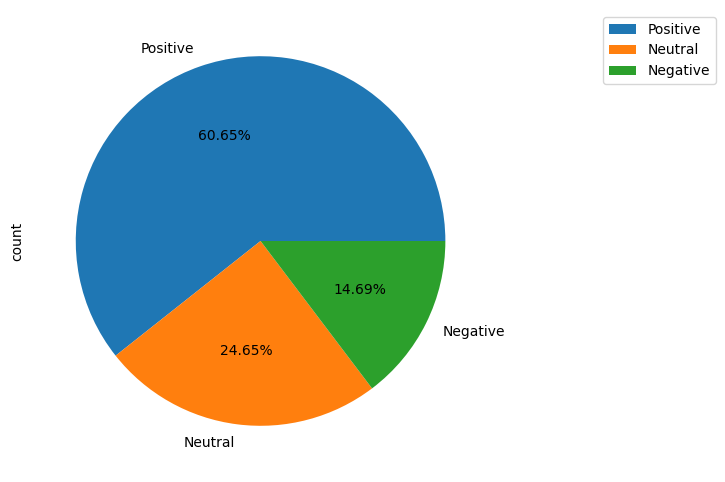

In [24]:
# pie chart with 'labels' column
plt.figure(figsize=(6,6))
explode=0.1,0
df.label.value_counts().plot.pie(autopct='%1.2f%%',labels=['Positive','Neutral','Negative'])
plt.legend(bbox_to_anchor=(1.5,1))
plt.show()

(np.float64(-0.5), np.float64(399.5), np.float64(199.5), np.float64(-0.5))

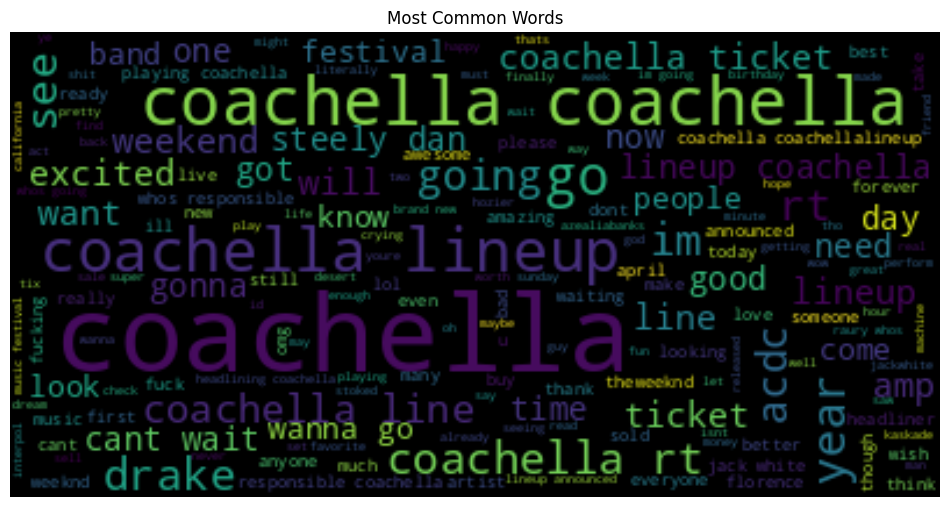

In [25]:
# Word Cloud
all_data = df['text'].to_string()
wordcloud = WordCloud().generate(all_data)
plt.figure(figsize=(12,8))
plt.imshow(wordcloud,interpolation='bilinear')
plt.title('Most Common Words')
plt.axis("off")

In [26]:
# Word Count - Top 20 most common words
temp_list = df['text'].apply(lambda x:str(x).split())
top = Counter([item for sublist in temp_list for item in sublist])
temp = pd.DataFrame(top.most_common(20))
temp.columns = ['Common_words','count']
temp.style.background_gradient(cmap='Blues')

,Common_words,count
0,coachella,4854
1,to,1356
2,the,1298
3,i,955
4,lineup,725
5,is,721
6,and,573
7,rt,518
8,for,513
9,this,426


In [27]:
text_lengths = df['text'].str.split().str.len()
text_lengths.value_counts().sort_values(ascending=False)

,count
text,
7,310
6,263
9,262
5,256
10,246
8,243
12,212
13,210
11,201


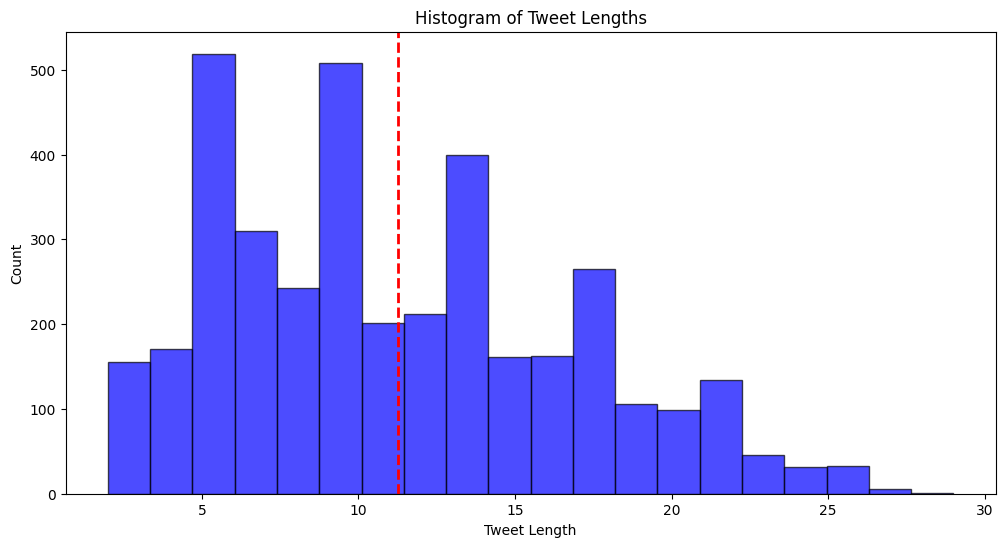

In [28]:
# Calculate the average
average_length = np.mean(text_lengths)

# Create a figure and axis
fig, ax = plt.subplots(figsize=(12, 6))

# Using plt.hist to create a histogram with Matplotlib
ax.hist(text_lengths, bins=20, color="blue", edgecolor="black", alpha=0.7)

# Add average line
ax.axvline(average_length, color='red', linestyle='dashed', linewidth=2, label=f'Average: {average_length:.2f}')

ax.set_title('Histogram of Tweet Lengths')
ax.set_xlabel('Tweet Length')
ax.set_ylabel('Count')

# Display the plot
plt.show()

## Train Test Split

In [29]:
# Split the train data => {train, eval}
train, eval = train_test_split(df, test_size=0.2, random_state=42, stratify=df['label'])

In [30]:
train.head()

,label,text
3469,0,i wish incubus or sonsofthesea would have been on the coachella lineup
2956,1,eric this is hilareous haha thatericalper this faux coachella lineup from coachella coachella
3584,0,gotta get my abs back for coachella but i love eating and sleeping way too much
3296,0,i hope it rains during drakes coachella set so everyone can talk about how they bathed in drakes tears coachella
1011,2,omg the coachella lineup soexcited


In [31]:
eval.head()

,label,text
1576,2,everyone is talking about the nflplayoffs and im just praying to see tupac at coachella rip
3577,0,ok back to oogling and crying at this lineup tt coachella
726,2,bring it coachella have my artist pass amp room ready to go
3197,1,coachella lineup preview coachella coachella coachellalineup
1,2,rt sudsybuddy wait this is absolute fire coachella


In [32]:
print(f"new dataframe shapes: train is {train.shape}, eval is {eval.shape}")

new dataframe shapes: train is (3011, 2), eval is (753, 2)


In [33]:
# Save split subsets
train.to_csv("/content/drive/MyDrive/Sentiment Analysis NLP/Dataset/train_subset.csv", index=False)
eval.to_csv("/content/drive/MyDrive/Sentiment Analysis NLP/Dataset/eval_subset.csv", index=False)

In [ ]:
# Load split subsets

dataset = load_dataset('csv',
                        data_files={'train': '/content/drive/MyDrive/Sentiment Analysis NLP/Dataset/train_subset.csv',
                        'eval': '/content/drive/MyDrive/Sentiment Analysis NLP/Dataset/eval_subset.csv'}, encoding = "ISO-8859-1")

NotImplementedError: Loading a dataset cached in a LocalFileSystem is not supported.

## Model Training and Fine Tuning

In [ ]:
#login to huggingface with access token

notebook_login()

In [ ]:
warnings.filterwarnings("ignore", category=FutureWarning)

nlp = f"cardiffnlp/twitter-roberta-base-sentiment-latest"
tokenizer = AutoTokenizer.from_pretrained(nlp)

config.json:   0%|          | 0.00/929 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/239 [00:00<?, ?B/s]

## Label and Text Processing

In [ ]:
def transform_labels(label):

    label = label['label']
    num = 0
    if label == -1: #'Negative'
        num = 0
    elif label == 0: #'Neutral'
        num = 1
    elif label == 1: #'Positive'
        num = 2

    return {'labels': num}

In [ ]:
# Function to tokenize data

def tokenize_data(example):
    return tokenizer(example['text'], padding=True, max_length = 'max_length')

In [ ]:
# Change the tweets to tokens that the model can use
dataset = dataset.map(tokenize_data, batched=True)

# Transform	labels and remove the useless columns
remove_columns = ['label', 'text']
dataset = dataset.map(transform_labels, remove_columns=remove_columns)

Map:   0%|          | 0/3011 [00:00<?, ? examples/s]

/usr/local/lib/python3.11/dist-packages/transformers/tokenization_utils_base.py:2718: UserWarning: `max_length` is ignored when `padding`=`True` and there is no truncation strategy. To pad to max length, use `padding='max_length'`.
  warnings.warn(


Map:   0%|          | 0/753 [00:00<?, ? examples/s]

Map:   0%|          | 0/3011 [00:00<?, ? examples/s]

Map:   0%|          | 0/753 [00:00<?, ? examples/s]

In [ ]:
dataset

DatasetDict({
    train: Dataset({
        features: ['input_ids', 'attention_mask', 'labels'],
        num_rows: 3011
    })
    eval: Dataset({
        features: ['input_ids', 'attention_mask', 'labels'],
        num_rows: 753
    })
})

### Balancing Target Classes

Since our target has imbalanced class weights (positive, neutral and negative dont have an equal number of samples), we want to give more weight to underrepresented classes and give less weight to classes with more samples.

In [ ]:
# Define the labels
labels = dataset['train']['labels']

# Apply the compute class weight function to calculate the class weight
class_weights = compute_class_weight('balanced', classes=np.unique(labels), y=labels)

The `balanced` option in compute_class_weight will calculate weights such that the classes are balanced.

In [ ]:
# Preview class weights
class_weights, np.unique(labels)

(array([2.26561324, 1.35265049, 0.54965316]), array([0, 1, 2]))

### Initialize pre-trained model

In [ ]:
# Define an instance of the pre-trained model with the number of labels
model = AutoModelForSequenceClassification.from_pretrained(nlp, num_labels=3)

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


pytorch_model.bin:   0%|          | 0.00/501M [00:00<?, ?B/s]

Some weights of the model checkpoint at cardiffnlp/twitter-roberta-base-sentiment-latest were not used when initializing RobertaForSequenceClassification: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [ ]:
# Configure the training parameters

training_args = TrainingArguments("Coachella_sentiment_analysis_roberta",
    num_train_epochs=5, # the number of times the model will repeat the training loop over the dataset
    load_best_model_at_end=True,
    eval_strategy='epoch',
    save_strategy='epoch',
)

In [ ]:
# evaluation metrics
metric = load("accuracy")

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    return metric.compute(predictions=predictions, references=labels)

FileNotFoundError: Couldn't find a module script at /content/accuracy/accuracy.py. Module 'accuracy' doesn't exist on the Hugging Face Hub either.

In [ ]:
# Instantiate the training and validation sets with random state of 10
train_dataset = dataset['train'].shuffle(seed=10)
eval_dataset = dataset['eval'].shuffle(seed=10)

In [ ]:
# Convert train data to PyTorch tensors to speed up training and add padding
data_collator = DataCollatorWithPadding(tokenizer=tokenizer,padding=True, max_length='max_length', return_tensors='pt')

In [ ]:
# Define Custom Trainer | Modify loss function and assign computed weights
class CustomTrainer(Trainer):
    def compute_loss(self, model, inputs, return_outputs=False, num_items_in_batch=None):
        labels = inputs.get("labels")
        # forward pass
        outputs = model(**inputs)
        logits = outputs.get("logits")

        # Ensure logits and labels have compatible shapes
        assert logits.shape[1] == self.model.config.num_labels, f"Logits shape {logits.shape} does not match number of labels {self.model.config.num_labels}"
        assert labels.max() < self.model.config.num_labels, f"Labels contain values outside the valid range: {labels}"

        # Ensure labels are of integer type
        assert labels.dtype == torch.long, f"Labels must be of type torch.long, but got {labels.dtype}"

        class_weights_tensor = torch.tensor(class_weights, dtype=torch.float32).to(model.device)

        # Compute custom loss
        loss_fct = nn.CrossEntropyLoss(weight=class_weights_tensor)
        loss = loss_fct(logits.view(-1, self.model.config.num_labels), labels.view(-1))
        return (loss, outputs) if return_outputs else loss

In [ ]:
# Instantiate the trainer for training
c_trainer = CustomTrainer(
                  model=model,
                  args=training_args,
                  train_dataset=train_dataset,
                  eval_dataset=eval_dataset,
                  tokenizer = tokenizer,
                  compute_metrics=compute_metrics,
)

In [ ]:
# Launch the learning process: training
c_trainer.train()

In [ ]:
# Launch the final evaluation
c_trainer.evaluate()

In [ ]:
# Push model and tokenizer to HF Hub
model.push_to_hub("Azie88/Coachella_sentiment_analysis_roberta")
tokenizer.push_to_hub("Azie88/Coachella_sentiment_analysis_roberta")
dataset.push_to_hub("Azie88/Coachella_sentiment_analysis_roberta")

This notebook is inspired by an article: [Fine-Tuning Bert for Tweets Classification ft. Hugging Face](https://medium.com/mlearning-ai/fine-tuning-bert-for-tweets-classification-ft-hugging-face-8afebadd5dbf)

## Inference
Let's test out our model with with some sample text

In [ ]:
model_path = f"Azie88/Coachella_sentiment_analysis_roberta"

tokenizer = AutoTokenizer.from_pretrained(model_path)
config = AutoConfig.from_pretrained(model_path)
model = AutoModelForSequenceClassification.from_pretrained(model_path)

In [ ]:
# Preprocess text (username and link placeholders)
def preprocess(text):
    new_text = []
    for t in text.split(" "):
        t = '@user' if t.startswith('@') and len(t) > 1 else t
        t = 'http' if t.startswith('http') else t
        new_text.append(t)
    return " ".join(new_text)

In [ ]:
# Input preprocessing
text = "that saturday lineup is fire, except for Jack White"
text = preprocess(text)

In [ ]:
# PyTorch-based models
encoded_input = tokenizer(text, return_tensors='pt')
output = model(**encoded_input)
scores = output[0][0].detach().numpy()
scores = softmax(scores)

In [ ]:
print("Scores:", scores)
print("id2label Dictionary:", config.id2label)

In [ ]:
config.id2label = {0: 'NEGATIVE', 1: 'NEUTRAL', 2: 'POSITIVE'}

In [ ]:
# Print labels and scores
ranking = np.argsort(scores)
ranking = ranking[::-1]
for i in range(scores.shape[0]):
    l = config.id2label[ranking[i]]
    s = scores[ranking[i]]
    print(f"{i+1}) {l} {np.round(float(s), 4)}")